In [1]:
pip install polars

  Using cached polars-1.14.0-cp39-abi3-win_amd64.whl.metadata (15 kB)
Using cached polars-1.14.0-cp39-abi3-win_amd64.whl (35.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import polars as pl
works_df = pl.read_csv("C:/Users/HP/Desktop/openalex-extractor/data/keywords.csv", infer_schema_length=10000)
# Assuming `works_df` contains a column `keywords` with a list or comma-separated string of keywords.
top_keywords = (
    works_df
    .select(pl.col("keywords"))
    .with_columns(
        # Split keywords into individual entries if stored as comma-separated strings
        pl.col("keywords").str.split(",").alias("keyword_list")
    )
    .explode("keyword_list")  # Flatten the list of keywords
    .group_by("keyword_list")
    .agg(pl.count("keyword_list").alias("frequency"))  # Count occurrences
    .filter(pl.col("keyword_list").is_not_null())  # Exclude null or empty keywords
    .sort("frequency", descending=True)  # Sort by frequency
    .head(30)  # Select top 30
)

# Display or save the result
top_keywords.write_csv("C:/Users/HP/Desktop/openalex-extractor/output/top_keywords.csv")
top_keywords


keyword_list,frequency
str,u32
""" Deep Learning""",53
""" Feature (linguistics)""",33
""" Intuitionistic Fuzzy Sets""",33
""" Benchmark (surveying)""",33
""" Nature-Inspired Algorithms""",31
…,…
""" Topic Modeling""",12
"""Robustness (evolution)""",12
""" Sentiment Analysis""",12


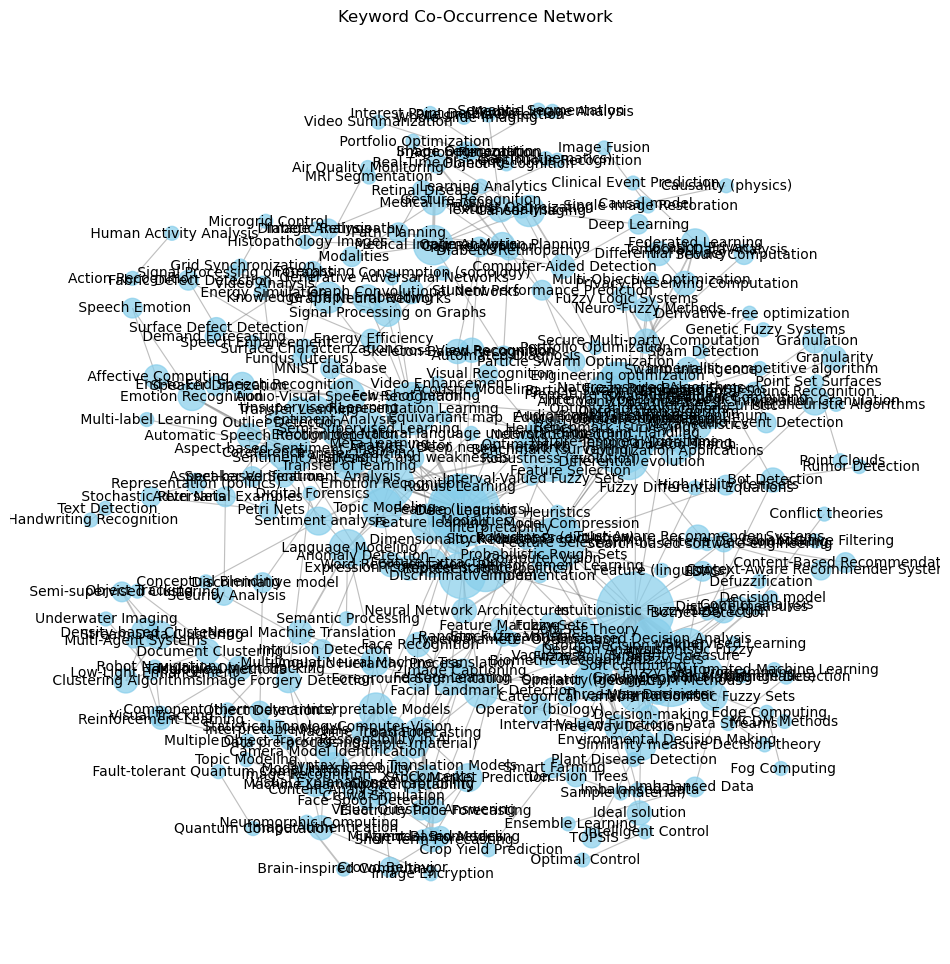

Graph saved to data/keyword_co_occurrence.graphml


In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import polars as pl

# Step 1: Load CSV file into Polars DataFrame
keywords_df = pl.read_csv("C:/Users/HP/Desktop/openalex-extractor/data/keywords.csv")


# Step 2: Split keywords into a list
keywords_df = keywords_df.with_columns(
    pl.col("keywords").str.split(",").alias("keywords_list")
)

# Step 3: Generate co-occurrence pairs and count occurrences
co_occurrence_data = []
for row in keywords_df.iter_rows(named=True):
    work_id = row["work_id"]
    keywords = row["keywords_list"]
    if len(keywords) > 1:
        pairs = list(combinations(keywords, 2))
        co_occurrence_data.extend([{"source": pair[0], "target": pair[1]} for pair in pairs])

# Step 4: Count co-occurrences
co_occurrence_df = pd.DataFrame(co_occurrence_data)
co_occurrence_df = co_occurrence_df.groupby(["source", "target"]).size().reset_index(name="weight")

# Step 5: Create the Co-occurrence Graph
G = nx.Graph()

# Add edges to the graph with weights
for _, row in co_occurrence_df.iterrows():
    if row["weight"] > 1:  # Only add edges with weight > 1 for clarity
        G.add_edge(row["source"], row["target"], weight=row["weight"])

# Step 6: Layout the graph using spring_layout for better visualization
pos = nx.spring_layout(G, seed=42, k=0.3)  # 'k' controls the distance between nodes

# Step 7: Draw the graph with customized parameters
plt.figure(figsize=(12, 12))
node_size = [G.degree(n) * 100 for n in G.nodes()]  # Size nodes based on degree (popularity of keyword)
edge_width = [G[u][v]["weight"] / max([G[u][v]["weight"] for u, v in G.edges()]) * 5 for u, v in G.edges()]

# Draw nodes, edges, and labels with adjusted parameters
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Step 8: Display the plot
plt.title("Keyword Co-Occurrence Network")
plt.axis("off")  # Turn off axis
plt.show()

# Step 7: Save the graph for further analysis (Gephi, Cytoscape)
nx.write_graphml(G, "C:/Users/HP/Desktop/openalex-extractor/output/keyword_co_occurrence.graphml")
print("Graph saved to data/keyword_co_occurrence.graphml")


In [11]:
import pandas as pd
from itertools import combinations
import polars as pl

# Step 1: Load the keywords CSV into a Polars DataFrame
keywords_df = pl.read_csv("C:/Users/HP/Desktop/openalex-extractor/data/keywords.csv")

# Step 2: Split keywords into a list
keywords_df = keywords_df.with_columns(
    pl.col("keywords").str.split(",").alias("keywords_list")
)

# Step 3: Generate co-occurrence pairs and count occurrences
co_occurrence_data = []
for row in keywords_df.iter_rows(named=True):
    work_id = row["work_id"]
    keywords = row["keywords_list"]
    if len(keywords) > 1:
        pairs = list(combinations(keywords, 2))
        co_occurrence_data.extend([{"source": pair[0], "target": pair[1]} for pair in pairs])

# Step 4: Count co-occurrences
co_occurrence_df = pd.DataFrame(co_occurrence_data)
co_occurrence_df = co_occurrence_df.groupby(["source", "target"]).size().reset_index(name="weight")

# Step 5: Generate Nodes CSV for VOSviewer
nodes = pd.DataFrame({"ID": list(set(co_occurrence_df["source"]).union(co_occurrence_df["target"])),
                      "Label": list(set(co_occurrence_df["source"]).union(co_occurrence_df["target"])),
                      "Type": ["Keyword"] * len(set(co_occurrence_df["source"]).union(co_occurrence_df["target"]))})

nodes.to_csv("C:/Users/HP/Desktop/openalex-extractor/outputnodes_for_vosviewer.csv", index=False)

# Step 6: Generate Edges CSV for VOSviewer
# Filter edges with co-occurrence greater than 1 for better clarity
co_occurrence_df_filtered = co_occurrence_df[co_occurrence_df["weight"] > 1]

co_occurrence_df_filtered.to_csv("C:/Users/HP/Desktop/openalex-extractor/output/edges_for_vosviewer.csv", index=False)

# Optional: Print the first few rows of both CSVs
print("Nodes CSV:")
print(nodes.head())

print("Edges CSV:")
print(co_occurrence_df_filtered.head())


Nodes CSV:
                       ID                   Label     Type
0         Control Systems         Control Systems  Keyword
1     Robust optimization     Robust optimization  Keyword
2     Supervised learning     Supervised learning  Keyword
3   Object-Based Analysis   Object-Based Analysis  Keyword
4    Condition Monitoring    Condition Monitoring  Keyword
Edges CSV:
                   source                            target  weight
62   Adversarial Examples                 Outlier Detection       2
63   Adversarial Examples                 Security Analysis       2
66    Affective Computing   Aspect-based Sentiment Analysis       2
74    Affective Computing                    Speech Emotion       2
76   Agent-Based Modeling                    Crowd Behavior       2


In [13]:
import pandas as pd

# Load your keywords data
# Assumes a CSV file with columns: 'year' and 'keywords'
data = pd.read_csv("C:/Users/HP/Desktop/openalex-extractor/data/works.csv")

# Explode keywords if stored as comma-separated values
data["keywords"] = data["keywords"].str.split(", ")
data = data.explode("keywords")

# Step 1: Aggregate keyword counts by year
keyword_counts = data.groupby(["publication_year", "keywords"]).size().reset_index(name="count")

# Step 2: Compute yearly totals for normalization
yearly_totals = keyword_counts.groupby("publication_year")["count"].sum().reset_index(name="total")
keyword_counts = keyword_counts.merge(yearly_totals, on="publication_year")
keyword_counts["normalized_count"] = keyword_counts["count"] / keyword_counts["total"]

# Step 3: Detect bursting keywords
# Calculate the rate of change (pseudo burst detection)
keyword_counts["rate_of_change"] = keyword_counts.groupby("keywords")["normalized_count"].diff()

# Compute burst strength
burst_strength = keyword_counts.groupby("keywords")["rate_of_change"].max().reset_index(name="Strength")

# Identify the begin and end of bursts
burst_period = keyword_counts[keyword_counts["rate_of_change"] > 0]
burst_period_agg = burst_period.groupby("keywords").agg(
    Begin=("publication_year", "min"), End=("publication_year", "max")
).reset_index()

# Merge burst strength with burst periods
burst_data = pd.merge(burst_strength, burst_period_agg, on="keywords")

# Step 4: Add column for sum of counts in 2022-2024
recent_counts = keyword_counts[keyword_counts["publication_year"].between(2022, 2024)]
recent_counts_sum = recent_counts.groupby("keywords")["count"].sum().reset_index(name="2022-2024")

# Merge with burst data
final_table = pd.merge(burst_data, recent_counts_sum, on="keywords", how="left").fillna(0)

# Sort by Strength and take the top 23
final_table = final_table.sort_values(by="Strength", ascending=False).head(23)

# Save to CSV
final_table.to_csv("C:/Users/HP/Desktop/openalex-extractor/output/top_23_bursting_keywords_table.csv", index=False)

# Display the table
print("Top 23 Bursting Keywords Table:")
print(final_table)


Top 23 Bursting Keywords Table:
                            keywords  Strength  Begin   End  2022-2024
77                     Deep Learning  0.013851   2023  2024         64
123            Feature (linguistics)  0.007596   2023  2023         35
220           Medical Image Analysis  0.005318   2024  2024         17
174         Identification (biology)  0.004927   2023  2023         19
7               Adversarial Examples  0.004514   2023  2024          7
352                Transfer Learning  0.004092   2023  2023         15
350                   Topic Modeling  0.003988   2024  2024         16
222                    Meta-Learning  0.003721   2024  2024         11
34                    Cancer Imaging  0.003463   2023  2024         13
342           Temporal Data Analysis  0.003453   2024  2024          5
104              Emotion Recognition  0.003422   2023  2023         22
166                       Heuristics  0.002659   2024  2024          9
26       Boosting (machine learning)  0.00265

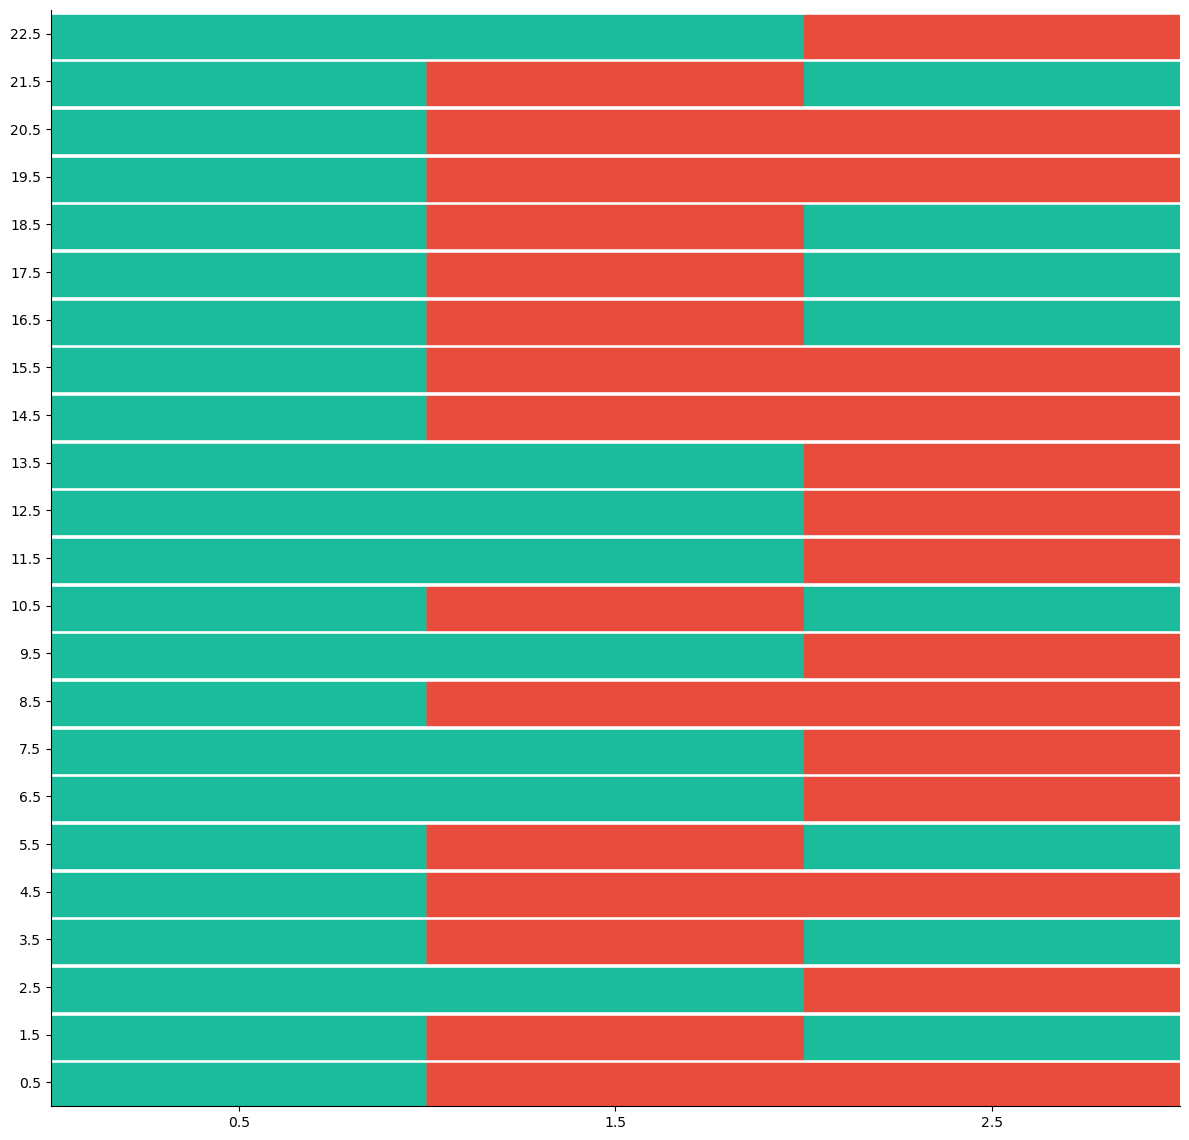

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Load data from the generated CSV file
file_path = "C:/Users/HP/Desktop/openalex-extractor/output/top_23_bursting_keywords_table.csv"  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Extract necessary columns (ensure your CSV has these columns)
# Adjust column names if they are different
keywords_column = "keywords"  # Replace with actual column name
strength_column = "Strength"  # Replace with actual column name
begin_column = "Begin"        # Replace with actual column name
end_column = "End"            # Replace with actual column name

df = df[[keywords_column, strength_column, begin_column, end_column]]  # Keep only relevant columns

# Define the range of years (modify as needed)
years_range = list(range(2022, 2025))  # Include all years from your dataset
year_labels = [str(year) for year in years_range]

# Function to plot a single row's activity
def plot_activity(ax, begin, end, row_index):
    colors = ['#E74C3C' if year in range(begin, end + 1) else '#1ABC9C' for year in years_range]
    for idx, color in enumerate(colors):
        ax.add_patch(Rectangle((idx, row_index), 1, 0.9, color=color))

# Create the plot
fig, ax = plt.subplots(figsize=(12, len(df) * 0.5))

# Draw each row based on the CSV data
for i, row in df.iterrows():
    plot_activity(ax, row[begin_column], row[end_column], i)

# Customize axes
ax.set_xlim(0, len(years_range))
ax.set_ylim(0, len(df))
ax.set_xticks(np.arange(len(years_range)) + 0.5)
ax.set_yticks(np.arange(len(df)) + 0.5)

# Hide grid and spines
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()


In [32]:
plt.tight_layout()
plt.savefig("C:/Users/HP/Desktop/openalex-extractor/output/bursting_keywords_timeline.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

In [37]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works.csv')

# Combine references for each work
result = df.groupby('work_id').agg({
    'referenced_work_id': lambda x: ', '.join(map(str, x)),
    'referenced_url': lambda x: ', '.join(x),
    'referenced_title': lambda x: ', '.join(x)
}).reset_index()

# Save the result to a new CSV file
result.to_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works_updated.csv', index=False)

print(result)

         work_id                     referenced_work_id  \
0    W3038105864  W1553483187, W1554474262, W1788095458   
1    W3044723170  W1485009520, W1522734439, W1533861849   
2    W3113149630  W1498436455, W1518178543, W1526328753   
3    W3120390034  W1480527676, W1494198834, W1498717522   
4    W3132799678   W1147193425, W132035103, W1516417927   
..           ...                                    ...   
721  W4401057135   W117026553, W1980264541, W1989314204   
722  W4401064736               W1522170132, W1965400972   
723  W4401101780  W1641498739, W1893631399, W1901129140   
724  W4401179606  W1542938076, W1964357740, W1973560868   
725  W4401375515   W115325191, W1515851193, W1532765750   

                                        referenced_url  \
0    https://api.openalex.org/works/W1553483187, ht...   
1    https://api.openalex.org/works/W1485009520, ht...   
2    https://api.openalex.org/works/W1498436455, ht...   
3    https://api.openalex.org/works/W1480527676, ht...   
4

In [36]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works.csv')

# Remove rows with blank (NaN) values in any column
df = df.dropna()

# Ensure all values in specific columns are strings, removing rows that aren't
columns_to_check = ['referenced_title']
for column in columns_to_check:
    df = df[df[column].apply(lambda x: isinstance(x, str))]

# Save the cleaned data to a new CSV file
df.to_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works.csv', index=False)

print("Cleaned data saved to 'referenced_works.csv'")


Cleaned data saved to 'referenced_works.csv'


In [42]:
import pandas as pd
from itertools import combinations
import networkx as nx

# Load the files
referenced_works = pd.read_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works_updated.csv')  # work_id, referenced_titles
work = pd.read_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/works.csv')  # id, title

# Merge work titles into the referenced_works DataFrame (optional, for better clarity)
work_titles = work.set_index('id')['title']
referenced_works['work_title'] = referenced_works['work_id'].map(work_titles)

# Split `referenced_titles` into lists
referenced_works['referenced_title'] = referenced_works['referenced_title'].apply(lambda x: x.split(', '))

# Create an empty graph for the co-citation network
G = nx.Graph()

# Add edges for co-cited references
for _, row in referenced_works.iterrows():
    references = row['referenced_title']
    # Create all pairs of co-cited references
    for ref1, ref2 in combinations(references, 2):
        if G.has_edge(ref1, ref2):
            G[ref1][ref2]['weight'] += 1  # Increment weight for existing edge
        else:
            G.add_edge(ref1, ref2, weight=1)  # Create a new edge

# Save the network to a file
nx.write_gml(G, 'C:/Users/HP/Desktop/openalex-extractor/output/co_citation_network.gml')

print("Co-citation network saved as 'co_citation_network.gml'")


Co-citation network saved as 'co_citation_network.gml'


In [44]:
import pandas as pd
from itertools import combinations

# Load the CSV files
referenced_works = pd.read_csv('C:/Users/HP/Desktop/openalex-extractor/new-data/referenced_works_updated.csv')  # work_id, referenced_titles

# Split `referenced_titles` into lists
referenced_works['referenced_title'] = referenced_works['referenced_title'].apply(lambda x: x.split(', '))

# Create an empty list to store edges
edges = []

# Generate edges for co-cited references
for _, row in referenced_works.iterrows():
    references = row['referenced_title']
    # Create all pairs of co-cited references
    for ref1, ref2 in combinations(references, 2):
        edges.append((ref1, ref2))

# Convert edges to a DataFrame
edges_df = pd.DataFrame(edges, columns=['Source', 'Target'])

# Calculate weights (frequency of co-citation)
edges_df = edges_df.groupby(['Source', 'Target']).size().reset_index(name='Weight')

# Save the edges to a CSV file for VOSviewer
edges_df.to_csv('C:/Users/HP/Desktop/openalex-extractor/output/vosviewer_edges.csv', index=False)

print("CSV file for VOSviewer saved as 'vosviewer_edges.csv'")


CSV file for VOSviewer saved as 'vosviewer_edges.csv'
